# 영상의 이진화

- 영상의 픽셀 값을 0 또는 255(1)로 만드는 연산
    - 배경 vs 객체
    - 관심 vs 비관심 영역

In [2]:
import numpy as np
import cv2
import random
import math
import matplotlib.pyplot as plt

### 세포 사진으로 이진화 확인 

In [2]:
src = cv2.imread("../data/cells.jpg", cv2.IMREAD_GRAYSCALE)

_, dst1 = cv2.threshold(src, 100, 255, cv2.THRESH_BINARY)
_, dst2 = cv2.threshold(src, 210, 255, cv2.THRESH_BINARY)

cv2.imshow('src', src)
cv2.imshow('dst1', dst1)
cv2.imshow('dst2', dst2)

cv2.waitKey()
cv2.destroyAllWindows()

### Otsu
- 자동으로 threshold를 잡고 싶으면
    - 영상의 히스토그램이 bimodal이고, 전경과 배경 픽셀 분포가 비슷하면...
    - 입력 영상이 배경과 객체 2개로 구성되어 있다 가정
    - 임의의 임계값 T에 의해 나눠지는 두 픽셀 분포 그룹의 분산이 최소가 되는 T를 선택.
    - 일종의 최적화 알고리즘

In [12]:
src = cv2.imread("../data/rice.jpg", cv2.IMREAD_GRAYSCALE)
scale = 0.5
src = cv2.resize(src, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

th, dst = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print("otsu's threshold:", th) # 131

cv2.imshow('src', src)
cv2.imshow('dst', dst)

cv2.waitKey()
cv2.destroyAllWindows()

otsu's threshold: 131.0


### 지역 이진화.
- 균일하지 않은 조명에서 일괄적인 threshold 적용은 문제가 되기에
- 분할시켜서 이진화!

In [26]:
src = cv2.imread("../data/sudoku.jpg", cv2.IMREAD_GRAYSCALE)
scale = 0.5
src = cv2.resize(src, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

bsize = 201
dst = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY, bsize, 5)

cv2.imshow('dst', dst)
cv2.imshow('src', src)
cv2.namedWindow('dst')

cv2.waitKey()
cv2.destroyAllWindows()

### 픽셀 라벨링
- 레이블링?
    - 동일 객체에 속한 모든 픽셀에 고유한 번호를 매기는 작업
    - 일반적으로 이진 영상에서 수행
    - OpenCV 3.x 버전부터 최신 논문 기반의 레이블링 알고리즘 함수를 제공

In [27]:
mat = np.array([
    [0, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 1, 0],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 0],
    [0, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]], np.uint8)

cnt, labels = cv2.connectedComponents(mat)

print('sep:', mat, sep='\n')
print('cnt:', cnt)
print('labels:', labels, sep='\n')

sep:
[[0 0 1 1 0 0 0 0]
 [1 1 1 1 0 0 1 0]
 [1 1 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 0]
 [0 0 0 1 1 1 1 0]
 [0 0 1 1 0 0 1 0]
 [0 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0]]
cnt: 4
labels:
[[0 0 1 1 0 0 0 0]
 [1 1 1 1 0 0 2 0]
 [1 1 1 1 0 0 0 0]
 [0 0 0 0 0 3 3 0]
 [0 0 0 3 3 3 3 0]
 [0 0 3 3 0 0 3 0]
 [0 0 3 3 3 3 3 0]
 [0 0 0 0 0 0 0 0]]


### 이번에는 객체 탐지하는 예제

In [ ]:
import cv2

# 1. 이미지 불러오기 (Grayscale로)
src = cv2.imread("../data/keyboard.jpg", cv2.IMREAD_GRAYSCALE)
scale = 0.5
src = cv2.resize(src, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

# 2. Otsu 알고리즘을 이용해 자동 임계값으로 이진화
_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# 3. 연결 요소 분석
cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(src_bin)

# 4. 결과 시각화를 위해 컬러 이미지로 변환
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

# 5. 각 객체에 대해 사각형 그리기 + 번호 표시
for i in range(1, cnt):  # i=0은 배경이므로 제외
    x, y, w, h, area = stats[i]

    if area < 20:  # 너무 작은 객체는 제외 (노이즈 제거)
        continue

    cv2.rectangle(dst, (x, y), (x + w, y + h), (0, 255, 255), 2)  # 노란 박스

# 6. 결과 출력
cv2.imshow('src', src)
cv2.imshow('src_bin', src_bin)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

### 외각선 검출 예제

In [50]:
src = cv2.imread("../data/contours.jpg", cv2.IMREAD_GRAYSCALE)

contours, hier = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# contours, hier = cv2.findContours(src, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

idx = 0
while idx >= 0:
    c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.drawContours(dst, contours, idx, c, 2, cv2.LINE_8, hier)
    idx = hier[0, idx, 0]

cv2.imshow('dst', dst)

cv2.waitKey()
cv2.destroyAllWindows()

### 계층 정보 없는 외곽선

In [66]:
import cv2
import numpy as np
import random

src = cv2.imread("../data/milkdrop.bmp", cv2.IMREAD_GRAYSCALE)

_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU)
contours, _ = cv2.findContours(src_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

h, w = src.shape[:2]
dst = np.zeros((h, w, 3), np.uint8)

for i in range(len(contours)):
    c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.drawContours(dst, contours, i, c, 1)

# 6. 결과 출력
cv2.imshow("src", src)
cv2.imshow("src_bin", src_bin)
cv2.imshow("dst", dst)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
def setLabel(img, pts, label):
    (x, y, w, h) = cv2.boundingRect(pts)
    pt = (x, y - 10)
    cv2.putText(img, label, pt, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

img = cv2.imread("../data/polygon.jpg", cv2.IMREAD_COLOR)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for pts in contours:
    if cv2.contourArea(pts) < 400:  # 너무 작으면 무시
        continue

    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)
    vtc = len(approx)

    if vtc == 3:
        setLabel(img, approx, 'TRI')  # 삼각형
    elif vtc == 4:
        setLabel(img, approx, 'RECT')  # 사각형
    else:
        length = cv2.arcLength(pts, True)
        area = cv2.contourArea(pts)
        ratio = 4.0 * math.pi * area / (length * length)
        if ratio > 0.85:
            setLabel(img, approx, 'CIR')  # 원

cv2.imshow('Shapes', img)
cv2.waitKey()
cv2.destroyAllWindows()

### 내용 요약용

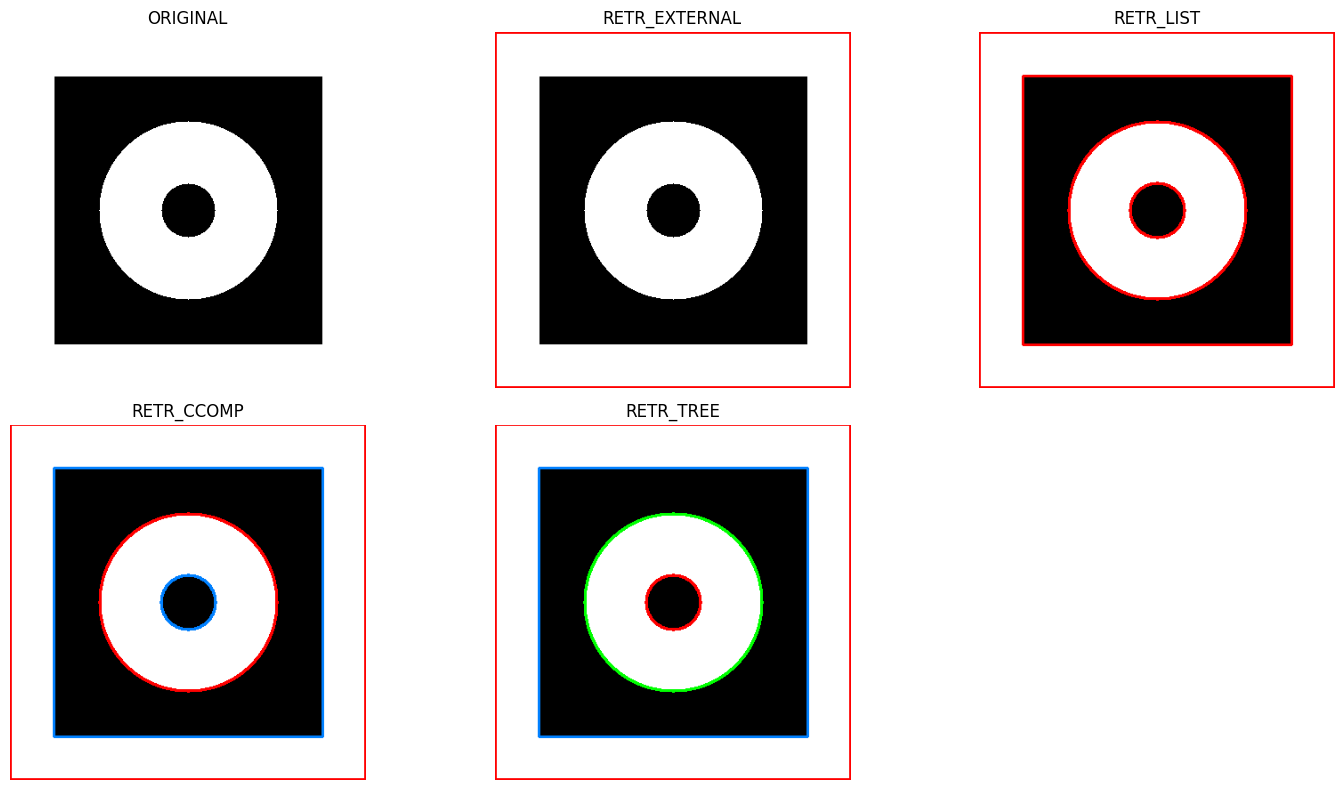

In [3]:
# 계층 시각화 비교: 각 RETR 모드별로 계층 단계가 있으면 색상, 없으면 빨간색만

# 1. 동일한 예제 이미지 생성
img = np.ones((400, 400), dtype=np.uint8) * 255
cv2.rectangle(img, (50, 50), (350, 350), 0, -1)
cv2.circle(img, (200, 200), 100, 255, -1)
cv2.circle(img, (200, 200), 30, 0, -1)
_, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

# 2. 정의: 계층 그리기 함수
colors = [(0, 0, 255), (255, 128, 0), (0, 255, 0), (0, 0, 255)]  # 계층별 색

def draw_contours_with_hierarchy(img, contours, hierarchy, idx=0, level=0):
    while idx != -1:
        color = colors[level % len(colors)]
        cv2.drawContours(img, contours, idx, color, 2)
        child = hierarchy[idx][2]
        draw_contours_with_hierarchy(img, contours, hierarchy, child, level + 1)
        idx = hierarchy[idx][0]

# 3. 비교할 모드
modes = [
    ("ORIGINAL", None),
    ("RETR_EXTERNAL", cv2.RETR_EXTERNAL),
    ("RETR_LIST", cv2.RETR_LIST),
    ("RETR_CCOMP", cv2.RETR_CCOMP),
    ("RETR_TREE", cv2.RETR_TREE),
]

results = []

for name, mode in modes:
    if mode is None:
        results.append((name, cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)))
        continue

    color_img = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR)
    contours, hierarchy = cv2.findContours(bin_img, mode, cv2.CHAIN_APPROX_SIMPLE)

    if hierarchy is not None:
        hierarchy = hierarchy[0]
        draw_contours_with_hierarchy(color_img, contours, hierarchy, 0, 0)
    else:
        # 계층 구조가 없으면 모두 빨간색
        cv2.drawContours(color_img, contours, -1, (0, 0, 255), 2)

    results.append((name, color_img))

# 4. 시각화
plt.figure(figsize=(15, 8))
for i, (title, img_result) in enumerate(results):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_result[..., ::-1])
    plt.title(title)
    plt.axis('off')



plt.tight_layout()
plt.show()
